In [1]:
import os        
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [2]:
# Trains a model to classify images of 3 classes: cat, dog, and panda
def gen_model():
    # Defines & compiles the model
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(rate=0.15), #adding dropout regularization throughout the model to deal with overfitting
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(rate=0.1),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(rate=0.10),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # 3 output neuron for the 3 classes of Animal Images
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

    return model

In [3]:
model = gen_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,495,587 (36.22 MB)

 Trainable params: 9,495,587 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def train_test_animals():
    from keras_preprocessing.image import ImageDataGenerator
    
    base_dir = 'CNN_MultiClass_data/CNN_MultiClass_data'

    # Splits data into training and testing (validation) sets
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)

    # Training data
    train_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'animals'),  # Source directory for training data
        target_size=(150, 150),  # Resizes images
        batch_size=15, # 15 img per batch
        class_mode='categorical',
        subset='training'
    )

    epochs = 10

    # Validation data
    validation_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'validation'),  # Same directory as training data
        target_size=(150, 150),
        batch_size=15,
        class_mode='categorical',
        subset='validation'  # Set as validation data
    )
    
    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
        )).repeat()
    
    validation_dataset = tf.data.Dataset.from_generator(
        lambda: validation_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32)
        )
    ).repeat()

    # Create the model
    model = gen_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Model fitting with adjusted steps_per_epoch and validation_steps
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = validation_generator.samples // validation_generator.batch_size
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        verbose=1
    )

    # Check available keys in history.history
    print("Available keys in history:", history.history.keys())  # Debugging line

    # Retrieve accuracy and loss history
    acc = history.history.get('accuracy', [])  # Use 'accuracy' instead of 'acc' for TensorFlow 2.x
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    # Ensure lengths are consistent
    if len(acc) != len(val_acc):
        print("Warning: Training and Validation accuracy lengths do not match!")

    # Print lengths for debugging
    print(f"Training Accuracy length: {len(acc)}")
    print(f"Validation Accuracy length: {len(val_acc)}")
    print(f"Training Loss length: {len(loss)}")
    print(f"Validation Loss length: {len(val_loss)}")

    # This code is used to plot the training and validation accuracy
    epochs_range = range(min(len(acc), len(val_acc)))  # Use the minimum length for x-axis

    plt.figure(figsize=(12, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc[:len(epochs_range)], label='Training Accuracy')  # Slice to match length
    plt.plot(epochs_range, val_acc[:len(epochs_range)], label='Validation Accuracy')  # Slice to match length
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss[:len(epochs_range)], label='Training Loss')  # Slice to match length
    plt.plot(epochs_range, val_loss[:len(epochs_range)], label='Validation Loss')  # Slice to match length
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Returns accuracy of training
    print("Training Accuracy:", acc[-1] if acc else 'N/A')
    print("Testing Accuracy:", val_acc[-1] if val_acc else 'N/A')
    
    return train_generator, validation_generator

In [5]:
#train_test_animals()

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - accuracy: 0.4109 - loss: 1.6520 - val_accuracy: 0.5573 - val_loss: 0.8448
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.6208 - loss: 0.7252 - val_accuracy: 0.6160 - val_loss: 0.7750
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 0.6814 - loss: 0.6574 - val_accuracy: 0.6453 - val_loss: 0.7008
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 376ms/step - accuracy: 0.7173 - loss: 0.5585 - val_accuracy: 0.6773 - val_loss: 0.6398
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 383ms/step - accuracy: 0.7755 - loss: 0.4905 - val_accuracy: 0.6627 - val_loss: 0.7208
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 365ms/step - accuracy: 0.7950 - loss: 0.4577 - val_accuracy: 0.6947 - val_loss: 0.6621
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 304ms/step - accuracy: 0.8494 - loss: 0.3316 - val_accuracy: 0.6827 - val_loss: 0.7428


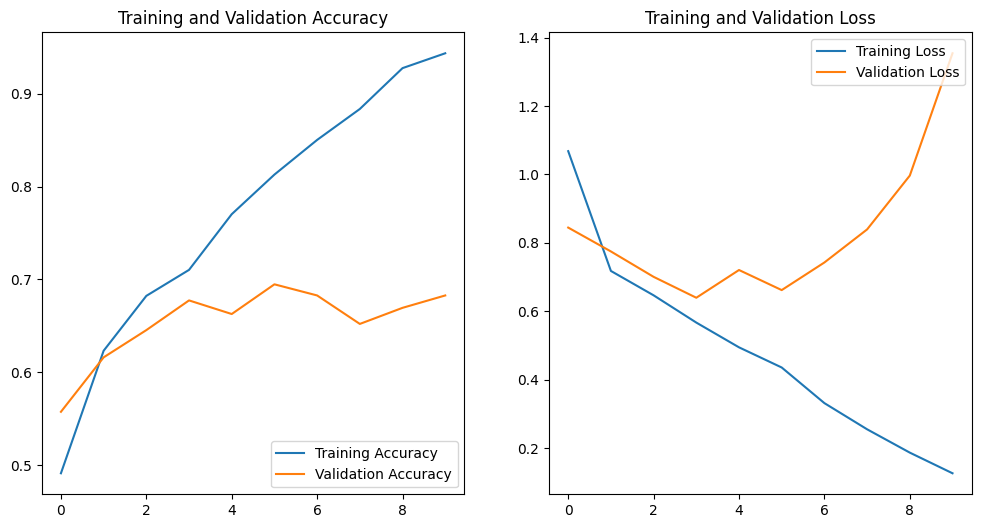

Training Accuracy: 0.9435555338859558
Testing Accuracy: 0.6826666593551636


In [7]:
import numpy as np

train_generator, validation_generator = train_test_animals()
# Số mẫu muốn lấy từ train_generator và validation_generator
num_samples_train = train_generator.samples
num_samples_validation = validation_generator.samples

# Hàm lấy dữ liệu từ generator và chuyển thành numpy array
def generator_to_numpy(generator, num_samples):
    X, y = [], []
    for _ in range(num_samples // generator.batch_size):
        batch_x, batch_y = next(generator)
        X.append(batch_x)
        y.append(batch_y)
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

# Tạo tập X_train và y_train từ train_generator
X_train, y_train = generator_to_numpy(train_generator, num_samples_train)

# Tạo tập X_test và y_test từ validation_generator
X_test, y_test = generator_to_numpy(validation_generator, num_samples_validation)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=225)
X_train_pca = pca.fit_transform(X_train.reshape(len(X_train), -1))
X_test_pca = pca.transform(X_test.reshape(len(X_test), -1))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_ann_model(input_shape):
    model = Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Khởi tạo và huấn luyện mô hình ANN với dữ liệu PCA
model_ann_pca = create_ann_model(X_train_pca.shape[1])
history_pca = model_ann_pca.fit(X_train_pca, y_train, epochs=10, validation_data=(X_test_pca, y_test))


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3690 - loss: 3.3020 - val_accuracy: 0.5440 - val_loss: 0.9254
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4608 - loss: 1.2951 - val_accuracy: 0.5440 - val_loss: 0.9147
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5152 - loss: 1.0531 - val_accuracy: 0.5693 - val_loss: 0.8885
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5442 - loss: 0.9321 - val_accuracy: 0.5587 - val_loss: 0.8872
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5472 - loss: 0.9039 - val_accuracy: 0.5587 - val_loss: 0.8708
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.8170 - val_accuracy: 0.5773 - val_loss: 0.8634
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6120 - loss: 0.8123 - val_accuracy: 0.6027 - val_loss: 0.8441
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6323 - loss: 0.7434 - val_accuracy: 0.6053 - val_loss

So sánh độ chính xác giữa hai mô hình ANN và CNN

Độ chính xác cuối cùng:
- ANN: 62.71% (độ chính xác) và 59.47% (độ chính xác trên validation)
- CNN: 96.34% (độ chính xác) và 72.00% (độ chính xác trên validation)

Tốc độ cải thiện:
- ANN: Độ chính xác tăng chậm và không đạt được độ chính xác cao.
- CNN: Độ chính xác tăng nhanh chóng, đặc biệt là trong các epoch cuối cùng, cho thấy mô hình học được nhiều đặc điểm hơn từ dữ liệu hình ảnh.

Kết luận
Mô hình CNN rõ ràng vượt trội hơn so với mô hình ANN trong cả độ chính xác và tốc độ học. Điều này là do CNN được thiết kế đặc biệt để xử lý dữ liệu hình ảnh, với các lớp convolutional giúp phát hiện và học các đặc điểm không gian trong ảnh. Ngược lại, ANN có thể không hiệu quả khi làm việc với dữ liệu hình ảnh mà không có cấu trúc không gian rõ ràng.

In [28]:
import numpy as np
from keras_preprocessing import image

def load_and_predict_image(model, img_path):
    # Tải ảnh và chuyển đổi kích thước
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0  # Chia cho 255 để chuẩn hóa
    img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch

    # Dự đoán
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)  # Lớp có xác suất cao nhất

    return predicted_class

# Sử dụng hàm để dự đoán một số ảnh mẫu
img_path = '1.jpg'  # Thay đổi đường dẫn đến ảnh của bạn
predicted_class = load_and_predict_image(model, img_path)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: [1]


In [29]:
# Tạo mô hình
def gen_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(rate=0.4),
        
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(rate=0.4),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        keras.layers.Dropout(rate=0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        
        # Chỉ định đầu ra cho 2 lớp
        tf.keras.layers.Dense(2, activation='softmax')  
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [30]:
model = gen_model()
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,495,074 (36.22 MB)

 Trainable params: 9,495,074 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
def cats_dogs_animals():
    from keras_preprocessing.image import ImageDataGenerator
    
    base_dir = 'CNN_MultiClass_data/CNN_MultiClass_data'

    # Tạo ImageDataGenerator với validation_split
    train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)

    train_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'animals'),
        target_size=(150, 150),
        batch_size=15,
        class_mode='categorical',
        subset='training',
        classes=['cats', 'dogs'] 
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'animals'),
        target_size=(150, 150),
        batch_size=15,
        class_mode='categorical',
        subset='validation',
        classes=['cats', 'dogs'] 
    )
    
    # Giới hạn số lượng mẫu
    train_generator.samples = min(train_generator.samples, 300)
    validation_generator.samples = min(validation_generator.samples, 100)

    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
        )).repeat()
    
    validation_dataset = tf.data.Dataset.from_generator(
        lambda: validation_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, validation_generator.num_classes), dtype=tf.float32)
        )
    ).repeat()
    
    
    # Create the model
    model = gen_model()
        
    # Huấn luyện mô hình
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = validation_generator.samples // validation_generator.batch_size
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        verbose=1
        )

    print("Training Accuracy:", history.history['accuracy'][-1])
    print("Validation Accuracy:", history.history['val_accuracy'][-1])
    
    return train_generator, validation_generator


In [49]:
cats_dogs_animals()

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.5253 - loss: 2.4919 - val_accuracy: 0.4333 - val_loss: 0.6944
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.4565 - loss: 0.6993 - val_accuracy: 0.5111 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.5406 - loss: 0.6926 - val_accuracy: 0.4444 - val_loss: 0.6944
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.5234 - loss: 0.6928 - val_accuracy: 0.4667 - val_loss: 0.6922
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.4241 - loss: 0.6968 - val_accuracy: 0.5444 - val_loss: 0.6922
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.4874 - loss: 0.6910 - val_accuracy: 0.4375 - val_loss: 0.6879
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.5149 - loss: 0.6916 - val_accuracy: 0.6333 - val_loss: 0.6787
Epoch 8/10
20/20 ━━━━

(<keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x1d7eeddc1a0>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x1d780a942c0>)